### Objetivo: Prever custos de um seguro de saúde baseados nas informações abaixo

    - age: idade
    - sex: sexo
    - bmi: IMC
    - children: quantidade de crianças
    - smoker: fumante
    - region: região em que a pessoa mora 
    - charges: gastos individuais cobrados pelo seguro de saúde




#### Bibliotecas

In [26]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline

#### Análise do dataset

    - Verificação da quantidade de linhas e colunas
    - Verificação se os tipos das features estão corretas
    - Verificação de valores nulos

In [27]:
data = pd.read_csv("insurance.csv")

print(data.shape)
print('-' * 50)
print(data.dtypes)
print('-' * 50)
print(data.iloc[1, :])

(1338, 7)
--------------------------------------------------
age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object
--------------------------------------------------
age                18
sex              male
bmi             33.77
children            1
smoker             no
region      southeast
charges     1725.5523
Name: 1, dtype: object


In [28]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [29]:
data = data.drop_duplicates()

**Análise das colunas**

    - Verificação de valores coeretentes/outliers

<Axes: xlabel='bmi', ylabel='Count'>

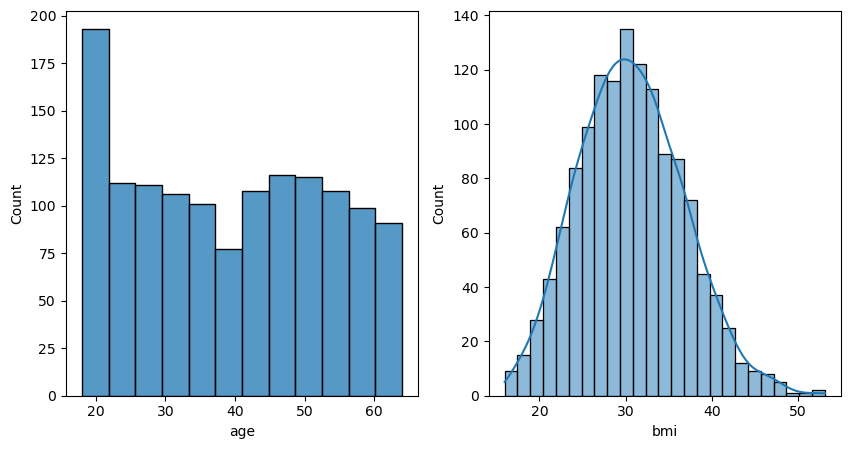

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(data['age'], ax=ax1)
sns.histplot(data['bmi'], kde=True, ax=ax2)

<Axes: xlabel='children', ylabel='count'>

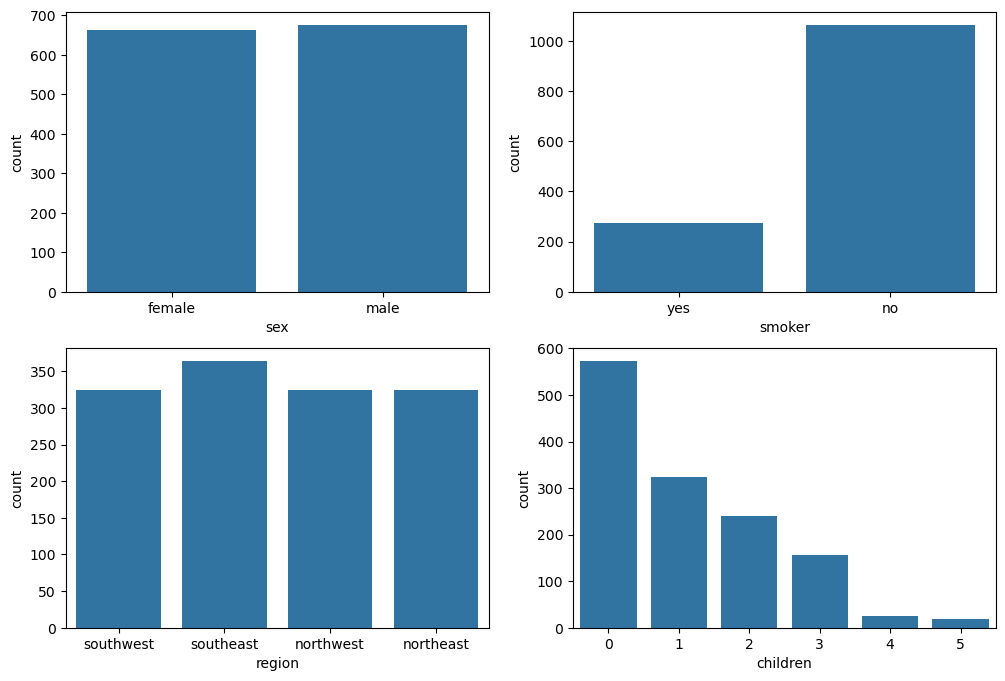

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12, 8))
sns.countplot(x=data['sex'], ax=ax1[0])
sns.countplot(x=data['smoker'], ax=ax1[1])
sns.countplot(x=data['region'], ax=ax2[0])
sns.countplot(x=data['children'], ax=ax2[1])

Limite superior: 34524.777625 | Valor máximo: 63770.42801
Limite inferior: -13120.716174999998 | Valor mínimo: 1121.8739


<Axes: ylabel='charges'>

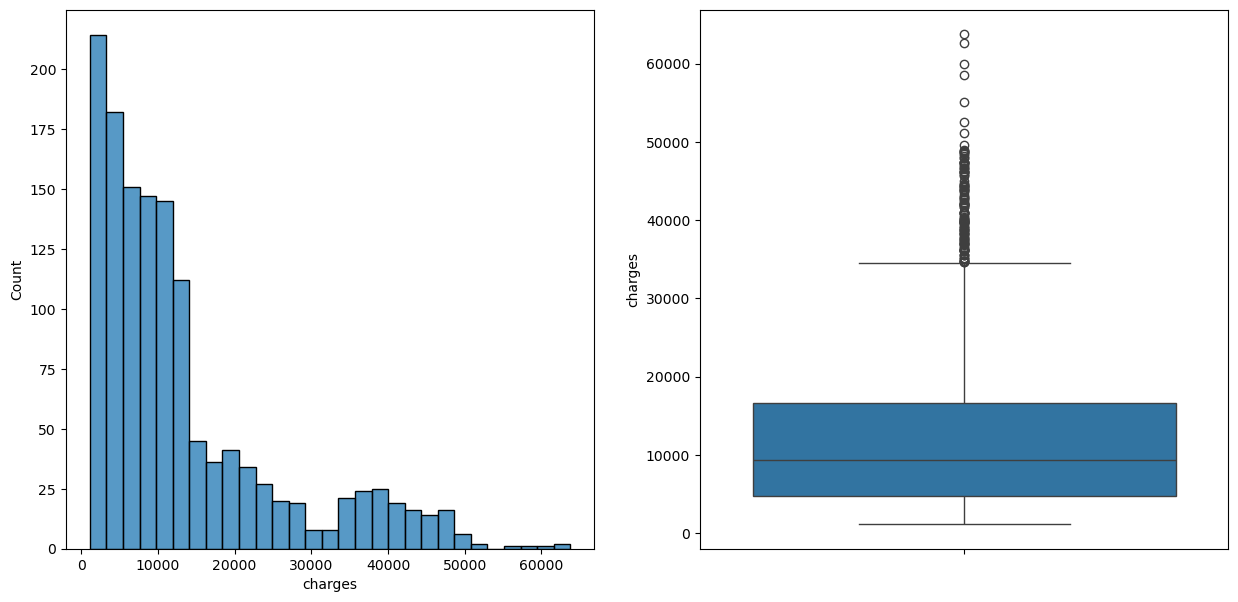

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
sns.histplot(data['charges'], ax=ax1)

amp = data['charges'].quantile(0.75) - data['charges'].quantile(0.25)
sup_lim = data['charges'].quantile(0.75) + 1.5*amp
inf_lim = data['charges'].quantile(0.25) - 1.5*amp

print(f"Limite superior: {sup_lim} | Valor máximo: {data['charges'].max()}")
print(f"Limite inferior: {inf_lim} | Valor mínimo: {data['charges'].min()}")
sns.boxplot(data['charges'], ax=ax2)


**Análise dos outliers**

    - Foi verificado que 97.8% das pessoas que ultrapassam o limite superior são fumantes, desse modo é bem possível que esse alto custo se de devido a essas complicações do cigarro. Dessa forma, apesar de terem valores que chegam quase ao dobro do limite superior, esses dados ainda serão considerados

In [33]:
data[data['charges'] >= sup_lim]['smoker'].value_counts()

smoker
yes    136
no       3
Name: count, dtype: int64

### Transformando colunas categóricas em colunas dummies

In [34]:
pd.set_option('future.no_silent_downcasting', True)
data['smoker'] = np.int8(data['smoker'].replace({'yes': 1, 'no': 0}))
categorical_columns = ['sex', 'region']
data = pd.get_dummies(data=data, columns=categorical_columns, dtype=np.int8)
data.head(3)

,age,bmi,children,smoker,charges,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.90,0,1,16884.9240,1,0,0,0,0,1
1,18,33.77,1,0,1725.5523,0,1,0,0,1,0
2,28,33.00,3,0,4449.4620,0,1,0,0,1,0


### Análise da correlação das variáveis 

    - Não há muito correlação entre as variáveis, somente entre o preço e se a pessoa é fumante, mas como se trata de custo hospitaleres somente essa informação não é o suficiente para uma regressão linear simples, visto que a idade, região e filhos também são fatores importantes

<Axes: >

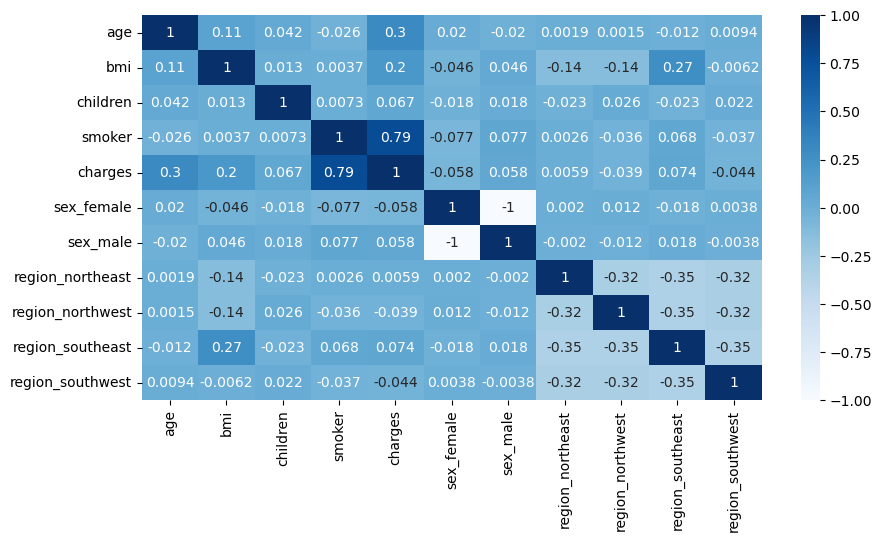

In [35]:
plt.figure(figsize=(10, 5))
sns.heatmap(data=data.corr(), annot=True, cmap='Blues')

### Normalização dos valores

In [36]:
from sklearn.preprocessing import StandardScaler


features_scaler = StandardScaler()
target_scaler = StandardScaler()
features = data.drop('charges', axis=1)
target = data['charges']
features_norm = features_scaler.fit_transform(features)
target_norm = target_scaler.fit_transform(target.values.reshape(-1 , 1))

In [47]:
features

,age,bmi,children,smoker,sex_female,sex_male,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,1,1,0,0,0,0,1
1,18,33.770,1,0,0,1,0,0,1,0
2,28,33.000,3,0,0,1,0,0,1,0
3,33,22.705,0,0,0,1,0,1,0,0
4,32,28.880,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1333,50,30.970,3,0,0,1,0,1,0,0
1334,18,31.920,0,0,1,0,1,0,0,0
1335,18,36.850,0,0,1,0,0,0,1,0
1336,21,25.800,0,0,1,0,0,0,0,1


### Treino dos modelos

#### Treino e teste

In [37]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(features, target, random_state=5)
x_train_norm, x_test_norm, y_train_norm, y_test_norm = train_test_split(features_norm, target_norm, random_state=5)

#### Métricas de avaliação

In [38]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold, cross_val_score


def error_test(y_test, y_predicted):
    
    print(f"Absolute Error: {mean_absolute_error(y_test, y_predicted)}")
    print(f"Root squared error: {np.sqrt(mean_squared_error(y_test, y_predicted))}")


def cross_test(model, features, target):
    
    kfold = KFold(n_splits=20, shuffle=True, random_state=7)
    cross_validation = cross_val_score(model, features, target, cv=kfold)
    print(f"Cross result: {cross_validation.mean():.2%}")



#### Multiple Linear Regression

In [39]:
from sklearn.linear_model import LinearRegression


multiple = LinearRegression()
multiple.fit(x_train, y_train)
test_predict = multiple.predict(x_test)

print(f"R^2:\n  test: {multiple.score(x_test, y_test):.2%}\n  train: {multiple.score(x_train, y_train):.2%}")
error_test(y_test, test_predict)
cross_test(multiple, features, target)

R^2:
  test: 73.45%
  train: 75.59%
Absolute Error: 4368.917976777767
Root squared error: 6325.89659037471
Cross result: 73.71%


#### SVM

In [40]:
from sklearn.svm import SVR


svr = SVR(kernel='rbf')
svr.fit(x_train_norm, y_train_norm.ravel())
test_predict = svr.predict(x_test_norm)


y_test_inverse = target_scaler.inverse_transform(y_test_norm)
test_predict_inverse = target_scaler.inverse_transform(test_predict.reshape(-1, 1))

print(f"R^2:\n  test: {svr.score(x_test_norm, y_test_norm):.2%}\n  train: {svr.score(x_train_norm, y_train_norm):.2%}")
error_test(y_test_inverse, test_predict_inverse)
cross_test(svr, features_norm, target_norm.ravel())

R^2:
  test: 83.47%
  train: 85.45%
Absolute Error: 2760.1486459993116
Root squared error: 4991.817686642452
Cross result: 83.44%


#### Decision Tree

In [41]:
from sklearn.tree import DecisionTreeRegressor


tree = DecisionTreeRegressor(max_depth=5, random_state=3)
tree.fit(x_train, y_train)
test_predict = tree.predict(x_test)


print(f"R^2:\n  test: {tree.score(x_test, y_test):.2%}\n  train: {tree.score(x_train, y_train):.2%}")
error_test(y_test, test_predict)
cross_test(tree, features, target)

R^2:
  test: 84.45%
  train: 87.74%
Absolute Error: 2815.3119026330946
Root squared error: 4841.564004302443
Cross result: 84.90%


#### Random Forest

In [42]:
from sklearn.ensemble import RandomForestRegressor


forest = RandomForestRegressor(max_depth=5, random_state=3, n_estimators=20)
forest.fit(x_train, y_train)
test_predict = forest.predict(x_test)


print(f"R^2:\n  test: {forest.score(x_test, y_test):.2%}\n  train: {forest.score(x_train, y_train):.2%}")
error_test(y_test, test_predict)
cross_test(forest, features, target)

R^2:
  test: 86.54%
  train: 88.85%
Absolute Error: 2549.4691679561224
Root squared error: 4503.866099002963
Cross result: 85.37%


#### XGBoost

In [43]:
from xgboost import XGBRegressor


xgboost = XGBRegressor(max_depth=3, learning_rate=0.07, n_estimators=70)
xgboost.fit(x_train, y_train)
test_predict = xgboost.predict(x_test)


print(f"R^2:\n  test: {xgboost.score(x_test, y_test):.2%}\n  train: {xgboost.score(x_train, y_train):.2%}")
error_test(y_test, test_predict)
cross_test(xgboost, features, target)

R^2:
  test: 86.44%
  train: 88.27%
Absolute Error: 2562.053877166324
Root squared error: 4520.920805954439
Cross result: 85.97%


#### LightGBM


In [44]:
import lightgbm as lgb


lgbm = lgb.LGBMRegressor(num_leaves=31, max_depth=3, learning_rate=0.06, n_estimators=90, 
                         min_split_gain=0.0, verbose=-1)
lgbm.fit(x_train, y_train)
test_predict = xgboost.predict(x_test)


print(f"R^2:\n  test: {lgbm.score(x_test, y_test):.2%}\n  train: {lgbm.score(x_train, y_train):.2%}")
error_test(y_test, test_predict)
cross_test(lgbm, features, target)

R^2:
  test: 86.05%
  train: 88.04%
Absolute Error: 2562.053877166324
Root squared error: 4520.920805954439
Cross result: 85.97%


#### CatBoost

In [45]:
from catboost.core import CatBoostRegressor

catboost = CatBoostRegressor(iterations=70, learning_rate=0.07, depth=5, random_state=3, verbose=0)
catboost.fit(x_train, y_train)
test_predict = catboost.predict(x_test)


print(f"R^2:\n  test: {catboost.score(x_test, y_test):.2%}\n  train: {catboost.score(x_train, y_train):.2%}")
error_test(y_test, test_predict)
cross_test(catboost, features, target)

R^2:
  test: 85.58%
  train: 87.84%
Absolute Error: 2658.122617304125
Root squared error: 4662.699544593033
Cross result: 85.75%


### Exportação do melhor modelo

In [46]:
import joblib as jb


jb.dump(forest, "model.pkl")
data.to_csv("modified_insurance.csv", encoding="utf-8", index=False)